# Pre-training on Casia webface

## Load the data

In [1]:
import tensorflow as tf, os, cv2, numpy as np
import keras, matplotlib.pyplot as plt

batch_size = 1024
image_size = 112
dataset = keras.utils.image_dataset_from_directory(
    os.path.join('data', 'Casia webface', 'archive', 'casia-webface'),
    labels = 'inferred',
    label_mode = 'int',
    batch_size = batch_size,
    image_size = (image_size, image_size),
    color_mode = 'rgb'
)



2024-11-08 10:23:51.078021: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1731050631.190923    4837 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1731050631.223434    4837 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-08 10:23:51.497411: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 490623 files belonging to 10572 classes.


I0000 00:00:1731050655.591913    4837 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5910 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3060 Ti, pci bus id: 0000:09:00.0, compute capability: 8.6


In [2]:
num_classes = 10572

## Configure the hyperparamters

In [3]:
learning_rate = 0.0001
weight_decay = 0.00001
num_epochs = 500
patch_size = 28
num_patches = (image_size // patch_size) ** 2
projection_dim = 64
num_heads = 6
transformer_units = [
    projection_dim * 2,
    projection_dim
]
transformer_layers = 8
mlp_head_units = [
    2048, 
    1024
]


## Date augmentation for better generalization

In [4]:
data_augmentation = keras.Sequential(
    [
        keras.layers.RandomFlip('horizontal'),
        keras.layers.RandomRotation(factor = 0.02),
        keras.layers.RandomZoom(height_factor = 0.2, width_factor = 0.2)
    ],
    name = 'data_augmentation'
)

## Patch creation layer

In [5]:
@keras.saving.register_keras_serializable("Patches")
class Patches(keras.layers.Layer):
    def __init__(self, patch_size, **kwargs):
        super().__init__(**kwargs)
        self.patch_size = patch_size
    
    def call(self, images):
        input_shape = keras.ops.shape(images)
        batch_size = input_shape[0]
        height = input_shape[1]
        width = input_shape[2]
        channels = input_shape[3]
        num_patches_h = height // self.patch_size
        num_patches_w = width // self.patch_size
        patches = keras.ops.image.extract_patches(images, size = self.patch_size)
        patches = keras.ops.reshape(
            patches,
            (
                batch_size,
                num_patches_h * num_patches_w,
                self.patch_size * self.patch_size * channels
            )
        )

        return patches

    def get_config(self):
        config = super().get_config()
        config.update({'patch_size' : self.patch_size})
        return {**config, 'patch_size' : self.patch_size}

## Demonstrate the patches in action

In [6]:
image = 0
for batch in dataset:
    image = batch[0][10]
    break

image = keras.ops.convert_to_tensor([image])

In [7]:
patches = Patches(patch_size)(image)

I0000 00:00:1731050672.381019    4837 cuda_dnn.cc:529] Loaded cuDNN version 90300


Image size: 112 X 112
Patch size: 28 X 28
Patches per image: 16
Elements per patch: 2352


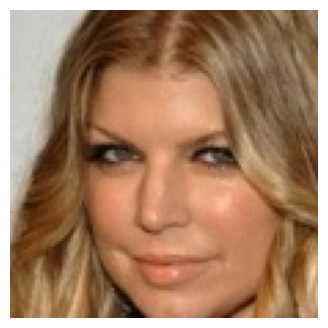

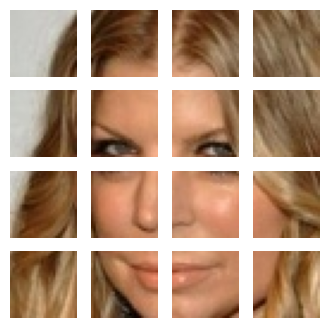

In [8]:
plt.figure(figsize = (4, 4))
plt.imshow(image[0].numpy().astype(np.uint8))
plt.axis('off')


n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = keras.ops.reshape(patch, (patch_size, patch_size, 3))
    plt.imshow(keras.ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

## Patch encoding layer

In [9]:
@keras.saving.register_keras_serializable("PatchEncoder")
class PatchEncoder(keras.layers.Layer):
    def __init__(self, num_patches, projection_dim, **kwargs):
        super().__init__(**kwargs)
        self.num_patches = num_patches
        self.projection_dim = projection_dim
        self.projection = keras.layers.Dense(units = self.projection_dim)
        self.position_embedding = keras.layers.Embedding(
            input_dim = num_patches,
            output_dim = projection_dim
        )
    
    def call(self, patches):
        positions = keras.ops.expand_dims(
            keras.ops.arange(start = 0, stop = self.num_patches, step = 1), axis = 0
        )
        projected_patches = self.projection(patches)
        encoded = projected_patches + self.position_embedding(positions)
        
        return encoded

    def get_config(self):
        config = super().get_config()
        return {**config, 'num_patches' : self.num_patches, 'projection_dim' : self.projection_dim}


## Build the Vision Transformer

In [10]:
def mlp(x, hidden_units, dropout_rate):
    for units in hidden_units:
        x = keras.layers.Dense(units, activation=keras.activations.gelu)(x)
        x = keras.layers.Dropout(dropout_rate)(x)
    return x

In [11]:
def create_vit_classifier():
    inputs = keras.Input(shape=(image_size, image_size, 3))
    # Augment data.
    augmented = data_augmentation(inputs)
    # Create patches.
    patches = Patches(patch_size)(augmented)
    # Encode patches.
    encoded_patches = PatchEncoder(num_patches, projection_dim)(patches)

    # Create multiple layers of the Transformer block.
    for _ in range(transformer_layers):
        # Layer normalization 1.
        x1 = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
        # Create a multi-head attention layer.
        attention_output = keras.layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=projection_dim, dropout=0.1
        )(x1, x1)
        # Skip connection 1.
        x2 = keras.layers.Add()([attention_output, encoded_patches])
        # Layer normalization 2.
        x3 = keras.layers.LayerNormalization(epsilon=1e-6)(x2)
        # MLP.
        x3 = mlp(x3, hidden_units=transformer_units, dropout_rate=0.1)
        # Skip connection 2.
        encoded_patches = keras.layers.Add()([x3, x2])

    # Create a [batch_size, projection_dim] tensor.
    representation = keras.layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    representation = keras.layers.Flatten()(representation)
    representation = keras.layers.Dropout(0.5)(representation)
    # Add MLP.
    features = mlp(representation, hidden_units=mlp_head_units, dropout_rate=0.5)
    # Classify outputs.
    outputs = keras.layers.Dense(num_classes, activation = keras.activations.softmax)(features)
    # Create the Keras model.
    model = keras.Model(inputs=inputs, outputs=outputs)
    return model

## Training

In [ ]:
checkpoint_path = os.path.join('data', 'checkpoint', 'ViT 1', 'ViT 1.weights.h5')

optimizer = keras.optimizers.AdamW(
    learning_rate = learning_rate,
    weight_decay = weight_decay
)

model = create_vit_classifier()
model.compile(
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [
        keras.metrics.SparseCategoricalAccuracy(name = 'accuracy'),
        keras.metrics.SparseTopKCategoricalAccuracy(name = 'top_5_accuracy')
    ]
)

model.load_weights(checkpoint_path)

checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor = 'accuracy',
    save_best_only = True,
    save_weights_only = True
)

learning_rate_scheduler = keras.callbacks.ReduceLROnPlateau('accuracy', 0.8)

history = model.fit(
    dataset,
    batch_size = batch_size,
    epochs = num_epochs,
    callbacks = [checkpoint_callback, learning_rate_scheduler]
)

## Pre-training on LFW

In [15]:
import tensorflow as tf, os, cv2, numpy as np
import keras, matplotlib.pyplot as plt
batch_size = 128
image_size = 112
learning_rate = 0.0001
weight_decay = 0.00001
dataset = keras.utils.image_dataset_from_directory(
    os.path.join('data', 'LFW', 'archive', 'lfw_funneled'),
    labels = 'inferred',
    label_mode = 'int',
    batch_size = batch_size,
    image_size = (image_size, image_size),
    color_mode = 'rgb'
)
num_classes = 5749

Found 13233 files belonging to 5749 classes.


In [ ]:
optimizer = keras.optimizers.AdamW(
    learning_rate = learning_rate,
    weight_decay = weight_decay
)

model = create_vit_classifier()
model.compile(
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [
        keras.metrics.SparseCategoricalAccuracy(name = 'accuracy'),
        keras.metrics.SparseTopKCategoricalAccuracy(name = 'top_5_accuracy')
    ]
)
checkpoint_path = os.path.join('data', 'checkpoint', 'ViT 2', 'ViT 2.weights.h5')
model.load_weights(checkpoint_path)
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor = 'accuracy',
    save_best_only = True,
    save_weights_only = True
)

history = model.fit(
    dataset,
    batch_size = batch_size,
    epochs = num_epochs,
    callbacks = [checkpoint_callback]
)

## Fine tuning

In [19]:
batch_size = 128
dataset = keras.utils.image_dataset_from_directory(
    os.path.join('data', 'Fine tuning DB'),
    labels = 'inferred',
    label_mode = 'int',
    batch_size = batch_size,
    image_size = (image_size, image_size)
)
num_classes = 2

Found 4413 files belonging to 2 classes.


In [ ]:
optimizer = keras.optimizers.AdamW(
    learning_rate = learning_rate,
    weight_decay = weight_decay
)

model = create_vit_classifier()
model.compile(
    optimizer = optimizer,
    loss = keras.losses.SparseCategoricalCrossentropy(),
    metrics = [
        keras.metrics.SparseCategoricalAccuracy(name = 'accuracy'),
        keras.metrics.SparseTopKCategoricalAccuracy(name = 'top_5_accuracy')
    ]
)

model.load_weights(
    os.path.join('data', 'checkpoint', 'ViT 2', 'ViT 2.weights.h5'),
    skip_mismatch = True,
)


checkpoint_path = os.path.join('data', 'checkpoint', 'ViT 3', 'ViT 3.weights.h5')
checkpoint_callback = keras.callbacks.ModelCheckpoint(
    checkpoint_path,
    monitor = 'accuracy',
    save_best_only = True,
    save_weights_only = True
)

history = model.fit(
    dataset,
    batch_size = batch_size,
    epochs = num_epochs,
    callbacks = [checkpoint_callback]
)